# Starter Kit: First International StepUP Competition (IJCB 2025)

This notebook provides example code for: 
1. Training a deep CNN for feature extraction, using the [Training Set](https://unbcloud-my.sharepoint.com/:u:/g/personal/q4k8p_unb_ca/EVpFj1lzB9pPtLBJq9Gp9NAB20McIFaIpaxSyiWlahTqIA?e=2z6AO2) (StepUP-P150 Database)
2. Loading the [Reference Set](https://unbcloud-my.sharepoint.com/:f:/g/personal/q4k8p_unb_ca/EkA7BgDKSRhDiKJXz_9tspIBKoMcgEEeNUJzwoZ_iXOymQ?e=QC3mQC) and applying the CNN for feature extraction
3. Loading the [Probe Set](https://unbcloud-my.sharepoint.com/:f:/g/personal/q4k8p_unb_ca/EpvpUtcKoodOux4kHiDQNsQBMFPxN-oSxSEgAV7mlsHpkQ?e=B5bLUE), applying the CNN for feature extraction, and using a distance-based metric to perform identity verification
4. Exporting the verification results in the format needed for submission to the [CodaBench platform](https://www.codabench.org/competitions/5872/)  


In [33]:
import numpy as np
import pathlib
import pandas as pd
import itertools
import zipfile
import os
import math

from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.utils import _triple
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from pytorch_metric_learning import losses
from scipy.spatial.distance import pdist, squareform, cdist

import umap
import matplotlib.pyplot as plt
import matplotlib as mpl

## Specify Dataset Filepaths

Before running this notebook, download the three [datasets](https://unbcloud-my.sharepoint.com/:f:/g/personal/q4k8p_unb_ca/EgGl2JeFJDNLiw35gBh5sjkBowFrY5-ACjhU3FRvmDXVRg?e=UC362K) and update the filepath below.

In [ ]:
# TODO: Update this filepath for your environment.
dataset_root = pathlib.Path('/home/robyn/StepUP/')

datapath_train = dataset_root / '1 - Training'
datapath_ref = dataset_root / '2 - Reference'
datapath_probe = dataset_root / '3 - Probe'

# Confirm that the dataset folders exist before contining.
# If this results in an error, double check that you have downloaded and extracted the dataset successfully and correctly updated the filepath above.
for filepath in [datapath_train, datapath_ref, datapath_probe]:
  assert(filepath.exists())


## Step 1. Training

### Define Feature Extraction Network
The architecture used for feature extraction is an R2Plus1D convolutional network implemented in PyTorch, modified from https://github.com/irhum/R2Plus1D-PyTorch 

In [ ]:
class SpatioTemporalConv(nn.Module):
    r"""Applies a factored 3D convolution over an input signal composed of several input 
    planes with distinct spatial and time axes, by performing a 2D convolution over the 
    spatial axes to an intermediate subspace, followed by a 1D convolution over the time 
    axis to produce the final output.

    Args:
        in_channels (int): Number of channels in the input tensor
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to the sides of the input during their respective convolutions. Default: 0
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(SpatioTemporalConv, self).__init__()

        # if ints are entered, convert them to iterables, 1 -> [1, 1, 1]
        kernel_size = _triple(kernel_size)
        stride = _triple(stride)
        padding = _triple(padding)

        # decomposing the parameters into spatial and temporal components by
        # masking out the values with the defaults on the axis that
        # won't be convolved over. This is necessary to avoid unintentional
        # behavior such as padding being added twice
        spatial_kernel_size =  [1, kernel_size[1], kernel_size[2]]
        spatial_stride =  [1, stride[1], stride[2]]
        spatial_padding =  [0, padding[1], padding[2]]

        temporal_kernel_size = [kernel_size[0], 1, 1]
        temporal_stride =  [stride[0], 1, 1]
        temporal_padding =  [padding[0], 0, 0]

        # compute the number of intermediary channels (M) using formula 
        # from the paper section 3.5
        intermed_channels = int(math.floor((kernel_size[0] * kernel_size[1] * kernel_size[2] * in_channels * out_channels)/ \
                            (kernel_size[1]* kernel_size[2] * in_channels + kernel_size[0] * out_channels)))

        # the spatial conv is effectively a 2D conv due to the 
        # spatial_kernel_size, followed by batch_norm and ReLU
        self.spatial_conv = nn.Conv3d(in_channels, intermed_channels, spatial_kernel_size,
                                    stride=spatial_stride, padding=spatial_padding, bias=bias)
        self.bn = nn.BatchNorm3d(intermed_channels)
        self.relu = nn.ReLU()

        # the temporal conv is effectively a 1D conv, but has batch norm 
        # and ReLU added inside the model constructor, not here. This is an 
        # intentional design choice, to allow this module to externally act 
        # identical to a standard Conv3D, so it can be reused easily in any 
        # other codebase
        self.temporal_conv = nn.Conv3d(intermed_channels, out_channels, temporal_kernel_size, 
                                    stride=temporal_stride, padding=temporal_padding, bias=bias)

    def forward(self, x):
        x = self.relu(self.bn(self.spatial_conv(x)))
        x = self.temporal_conv(x)
        return x
    
class SpatioTemporalResBlock(nn.Module):
    r"""Single block for the ResNet network. Uses SpatioTemporalConv in 
        the standard ResNet block layout (conv->batchnorm->ReLU->conv->batchnorm->sum->ReLU)
        
        Args:
            in_channels (int): Number of channels in the input tensor.
            out_channels (int): Number of channels in the output produced by the block.
            kernel_size (int or tuple): Size of the convolving kernels.
            downsample (bool, optional): If ``True``, the output size is to be smaller than the input. Default: ``False``
        """
    def __init__(self, in_channels, out_channels, kernel_size, downsample=False):
        super(SpatioTemporalResBlock, self).__init__()
        
        # If downsample == True, the first conv of the layer has stride = 2 
        # to halve the residual output size, and the input x is passed 
        # through a seperate 1x1x1 conv with stride = 2 to also halve it.

        # no pooling layers are used inside ResNet
        self.downsample = downsample
        
        # to allow for SAME padding
        padding = kernel_size//2

        if self.downsample:
            # downsample with stride =2 the input x
            self.downsampleconv = SpatioTemporalConv(in_channels, out_channels, 1, stride=2)
            self.downsamplebn = nn.BatchNorm3d(out_channels)

            # downsample with stride = 2when producing the residual
            self.conv1 = SpatioTemporalConv(in_channels, out_channels, kernel_size, padding=padding, stride=2)
        else:
            self.conv1 = SpatioTemporalConv(in_channels, out_channels, kernel_size, padding=padding)

        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU()

        # standard conv->batchnorm->ReLU
        self.conv2 = SpatioTemporalConv(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.outrelu = nn.ReLU()

    def forward(self, x):
        res = self.relu1(self.bn1(self.conv1(x)))    
        res = self.bn2(self.conv2(res))

        if self.downsample:
            x = self.downsamplebn(self.downsampleconv(x))

        return self.outrelu(x + res)

class SpatioTemporalResLayer(nn.Module):
    r"""Forms a single layer of the ResNet network, with a number of repeating 
    blocks of same output size stacked on top of each other
        
        Args:
            in_channels (int): Number of channels in the input tensor.
            out_channels (int): Number of channels in the output produced by the layer.
            kernel_size (int or tuple): Size of the convolving kernels.
            layer_size (int): Number of blocks to be stacked to form the layer
            block_type (Module, optional): Type of block that is to be used to form the layer. Default: SpatioTemporalResBlock. 
            downsample (bool, optional): If ``True``, the first block in layer will implement downsampling. Default: ``False``
        """

    def __init__(self, in_channels, out_channels, kernel_size, layer_size, block_type=SpatioTemporalResBlock, downsample=False):
        
        super(SpatioTemporalResLayer, self).__init__()

        # implement the first block
        self.block1 = block_type(in_channels, out_channels, kernel_size, downsample)

        # prepare module list to hold all (layer_size - 1) blocks
        self.blocks = nn.ModuleList([])
        for i in range(layer_size - 1):
            # all these blocks are identical, and have downsample = False by default
            self.blocks += [block_type(out_channels, out_channels, kernel_size)]

    def forward(self, x):
        x = self.block1(x)
        for block in self.blocks:
            x = block(x)

        return x

class R2Plus1DNet(nn.Module):
    r"""Forms the overall ResNet feature extractor by initializng 5 layers, with the number of blocks in 
    each layer set by layer_sizes, and by performing a global average pool at the end producing a 
    512-dimensional vector for each element in the batch.
        
        Args:
            layer_sizes (tuple): An iterable containing the number of blocks in each layer
            block_type (Module, optional): Type of block that is to be used to form the layers. Default: SpatioTemporalResBlock. 
        """
    def __init__(self, layer_sizes, block_type=SpatioTemporalResBlock,n_channels = 3):
        super(R2Plus1DNet, self).__init__()

        # first conv, with stride 1x2x2 and kernel size 3x7x7
        self.conv1 = SpatioTemporalConv(n_channels, 64, [3, 7, 7], stride=[1, 2, 2], padding=[1, 3, 3])
        # output of conv2 is same size as of conv1, no downsampling needed. kernel_size 3x3x3
        self.conv2 = SpatioTemporalResLayer(64, 64, 3, layer_sizes[0], block_type=block_type)
        # each of the final three layers doubles num_channels, while performing downsampling 
        # inside the first block
        self.conv3 = SpatioTemporalResLayer(64, 128, 3, layer_sizes[1], block_type=block_type, downsample=True)
        self.conv4 = SpatioTemporalResLayer(128, 256, 3, layer_sizes[2], block_type=block_type, downsample=True)
        self.conv5 = SpatioTemporalResLayer(256, 512, 3, layer_sizes[3], block_type=block_type, downsample=True)

        # global average pooling of the output
        self.pool = nn.AdaptiveAvgPool3d(1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.pool(x)
        
        return x.view(-1, 512)

class R2Plus1DClassifier(nn.Module):
    r"""Forms a complete ResNet classifier producing vectors of size num_classes, by initializng 5 layers, 
    with the number of blocks in each layer set by layer_sizes, and by performing a global average pool
    at the end producing a 512-dimensional vector for each element in the batch, 
    and passing them through a Linear layer.
        
        Args:
            num_classes(int): Number of classes in the data
            layer_sizes (tuple): An iterable containing the number of blocks in each layer
            block_type (Module, optional): Type of block that is to be used to form the layers. Default: SpatioTemporalResBlock. 
        """
    def __init__(self, num_classes, layer_sizes, block_type=SpatioTemporalResBlock, n_channels = 3):
        super(R2Plus1DClassifier, self).__init__()

        self.res2plus1d = R2Plus1DNet(layer_sizes, block_type,n_channels = n_channels)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        embeds = self.res2plus1d(x)
        x = self.linear(embeds) 

        return x,embeds   

### Load Training Metadata
Load the StepUP-P150 metadata. This loads metadata for entire dataset by default, but can be filtered as desired - modify `participant_IDs`, `speed_IDs` and `footwear_IDs` to load fewer individuals or conditions. Refer to the following descriptions of the conditions:


| Speed ID | Description | | Footwear ID | Description |
| --- | --- | --- | --- | --- |
| W1 | Preferred Speed | | BF | Without Footwear (Barefoot or Sockfoot) |
| W2 | Slow-to-Stop | | ST | Standard Sneakers (Adidas Grand Court 2.0) |
| W3 | Slower than Preferred | | P1 | Participant's First Pair of Personal Footwear | 
| W4 | Faster than Preferred | | P2 | Participant's Second Pair of Personal Footwear | 


In [5]:
participant_IDs = np.arange(1,151)
speed_IDs = ['W1','W2','W3','W3']
footwear_IDs = ['BF','ST','P1','P2']

metadata_lst = []
for participant_ID, footwear_ID, speed_ID in itertools.product(participant_IDs, footwear_IDs, speed_IDs):
  metadata_path = datapath_train / f'{participant_ID:03}' / footwear_ID / speed_ID / 'metadata.csv'
  metadata_lst.append(pd.read_csv(metadata_path))

metadata_train = pd.concat(metadata_lst).reset_index(drop=True)

# Remove any samples flagged to 'Exclude': these are incomplete or outlier footsteps 
metadata_train = metadata_train.query('Exclude == False')

metadata_train.head()

,ParticipantID,Footwear,Speed,FootstepID,PassID,StartFrame,EndFrame,Ymin,Ymax,Xmin,...,Side,Standing,Incomplete,Rscore,Outlier,Exclude,RotationAngle,FootLength,FootWidth,MeanGRF
0,1,BF,W1,0,0,212,288,76,131,167,...,Right,0,0,0.248545,0,0,4.246666,53.0,19.0,23270.396040
1,1,BF,W1,1,0,276,348,233,291,191,...,Left,0,0,1.126682,0,0,1.618202,55.0,20.0,25024.029703
2,1,BF,W1,2,0,331,407,385,439,167,...,Right,0,0,0.511779,0,0,4.133031,53.0,19.0,19953.871287
3,1,BF,W1,3,0,393,469,537,593,189,...,Left,0,0,0.188634,0,0,3.611146,55.0,18.0,20826.940594
5,1,BF,W1,5,1,592,670,608,661,49,...,Right,0,0,0.345517,0,0,-10.230420,53.0,20.0,21352.158416


### Define a Dataset Class for the Training Set

This class loads the training samples as they are needed during batch creation. Each footstep has a size of 101 $\times$ 75 $\times$ 40 (time frames, height, width). They have been normalized in time and roughly aligned, but not spatially resized or normalized in amplitude (see the Pipeline 1 normalization steps in the [dataset descriptor](https://arxiv.org/abs/2502.17244) for more information).


**Note**: this dataloader automatically flips right footsteps along their x-axis so that all samples appear like 'left' footsteps. This is to improve sample uniformity during model training. 

In [6]:
class Training_Dataset(Dataset):
    def __init__(self, datapath, metadata,transform=None):
        self.datapath = datapath
        self.transform = transform
        self.participant_IDs = metadata['ParticipantID'].to_numpy() 
        self.side = metadata['Side'].to_numpy()
        self.footstep_IDs = metadata['FootstepID'].to_numpy()
        self.footwear_IDs = metadata['Footwear'].to_numpy()
        self.speed_IDs = metadata['Speed'].to_numpy()

        # transform labels into integers starting at 0
        le = LabelEncoder()
        self.labels = le.fit_transform(self.participant_IDs)
        self.n_classes = np.unique(self.labels).shape[0]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        footstep_ID = int(self.footstep_IDs[idx])
        participant_ID = self.participant_IDs[idx]
        footwear_ID = self.footwear_IDs[idx]
        speed_ID = self.speed_IDs[idx]

        # load footstep sample
        sample_path = self.datapath / f'{participant_ID:03}' / footwear_ID / speed_ID / 'pipeline_1.npz' 
        footsteps = np.load(sample_path)
        footstep = footsteps[f'{footstep_ID}']

        # flip right footsteps along x axis
        if self.side[idx] == 'Right':
            footstep = np.flip(footstep,axis = 2)
        
        # add dimension for channel: shape (1,101,75,40) (channel,time,y,x)
        footstep = footstep[None,:,:,:]

        x = torch.from_numpy(footstep.astype(np.float32))
        y = torch.tensor(self.labels[idx])
        
        if self.transform:
            x = self.transform(x)
            
        return x, y

### Train Network

Define transformation functions for the footsteps. These normalize the amplitude of each footstep between 0 and 1 and downsample them spatially and temporally to 16 frames $\times$ 32 pixels $\times$ 16 pixels.

In [7]:
# min-max scaling to normalize between zero and 1
def normalize(x): 
    x = (x - x.min())/(x.max() - x.min())
    if torch.isnan(x).any():
        x[torch.isnan(x)] = 0
    return x

# use linear interpolation to downsample 3D footstep
def resize(x,size = (16,32,16)): 
    x = F.interpolate(x.unsqueeze(0) ,size = size,mode = 'trilinear')
    return x.squeeze(0)

Specify training conditions and hyperparameters

In [8]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# specify training conditions 
train_users = np.arange(1,151)
train_speeds = ['W1','W2','W3','W4'] 
train_shoes = ['BF','ST','P1','P2']
metadata_train = metadata_train.query('ParticipantID in @train_users and Speed in @train_speeds and Footwear in @train_shoes')

# set training hyperparameters
batch_sz = 124
n_epochs = 15
sample_sz = (16,32,16) # downsample image to size (time,height,width)

# create transformation pipeline for training set
transform_fn = transforms.Compose([
    resize,
    normalize,
])

# create dataset and data loader
dataset = Training_Dataset(datapath_train, metadata_train,transform = transform_fn)
dataloader = DataLoader(dataset, batch_size=batch_sz, shuffle=True)

# create network
clf = R2Plus1DClassifier(dataset.n_classes, [2,2,2,2,2], n_channels = 1)
clf.to(device)
clf.train()

# use a contrastive loss
loss_func = losses.ContrastiveLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, n_epochs, last_epoch=-1)

Plot a few of the transformed training samples. The 3D samples have been flattened into 2D images for display.

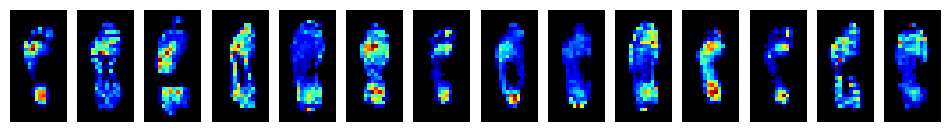

In [31]:
# get one batch of training footsteps
data_iter = iter(dataloader)
footsteps, labels = next(data_iter)  

fig, ax = plt.subplots(1, 14, figsize=(12, 4))

# define colormap
jet = mpl.colormaps['jet'](np.linspace(0, 1, 256))
jet[0] = [0,0,0,1]
cmap = mpl.colors.ListedColormap(jet)

for i in range(14):
    footstep = footsteps[i].squeeze()
    img = footstep.max(0)[0] # flatten into image for display
    ax[i].imshow(img,cmap = cmap)
    ax[i].set_axis_off()
plt.show()

Train the model for n_epochs. Save checkpoints after each epoch.

**Note**: to save time, you can skip this cell and load in the pretrained model in the following cell.

In [ ]:
# Train model for n_epochs
for epoch in range(n_epochs):
    print('Epoch:',epoch)
    
    # Loop over all batches using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_batch_pred,embeds = clf(x_batch)

        loss = loss_func(embeds, y_batch)

        print('Loss:', loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()

    # save checkpoints
    state = {
    'clf': clf.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'loss_func':loss_func.state_dict(),
    'loss': loss,
    'epoch': epoch}

    torch.save(state, 'model_snapshot_%d.pt' % epoch)

Load trained model weights from saved checkpoint.

In [12]:
checkpoint = torch.load('model_snapshot_4.pt',weights_only = True, map_location = device)
clf.load_state_dict(checkpoint['clf'])

<All keys matched successfully>

Extract and then plot a UMAP projection of the CNN embeddings for a subset of the training samples. Each sample is represented by 512 features.  

In [13]:
clf.eval()

train_embeds = []
train_labs = []
with torch.no_grad():

    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        if id_batch >= 100:  # get embeddings for first 100 batches
            break
        
        x_batch =  x_batch.to(device)

        with torch.no_grad():
            y_batch_pred,embeds = clf(x_batch)
            embeds = embeds.cpu()
        train_embeds.append(embeds)
        train_labs.append(y_batch.numpy())  

train_embeds = np.concatenate(train_embeds, axis = 0)
train_labs = np.concatenate(train_labs, axis = 0)

print('Number of features per sample:', train_embeds.shape[1])

Number of features per sample: 512


/home/robyn/StepUP/StepUP-P150/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/robyn/StepUP/StepUP-P150/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


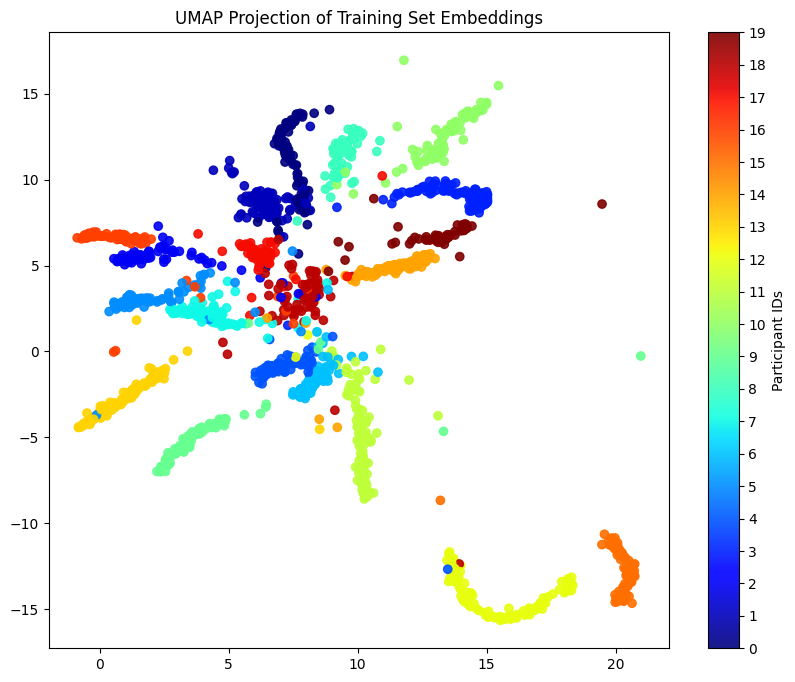

In [14]:
reducer = umap.UMAP(min_dist = 0.8)
umap_proj = reducer.fit_transform(train_embeds)

# plot only first 20 users
user_idx = np.isin(train_labs,np.unique(train_labs)[0:20])

fig,ax = plt.subplots(figsize=(10, 8))
scatter = plt.scatter(umap_proj[user_idx, 0], umap_proj[user_idx, 1], c=train_labs[user_idx], cmap='jet', vmin = train_labs[user_idx].min(), vmax = train_labs[user_idx].max(), alpha=0.9)
plt.colorbar(scatter,ticks = np.unique(train_labs[user_idx]), label = 'Participant IDs')
plt.title("UMAP Projection of Training Set Embeddings")
plt.show()

## Step 2. Get Embeddings for Reference Samples

### Load Metadata and Data
The reference set consists of 15 users with 10 footstep samples each (5 left and 5 right). The metadata for the reference set is stored in a single spreadsheet, and the footsteps are stored in a dictionary format (one key per footstep) in a single .npz file. 

In [15]:
metadata_ref = pd.read_csv(datapath_ref / 'reference_metadata.csv',index_col = 'Index')
footsteps_ref = np.load(datapath_ref / 'reference_data.npz')

metadata_ref.head()

,ParticipantID,Side
Index,,
0,1001,Left
1,1001,Left
2,1001,Right
3,1001,Left
4,1001,Right


Plot 2D images of all 150 reference footsteps. They have been processed in the same way as the Training dataset. 

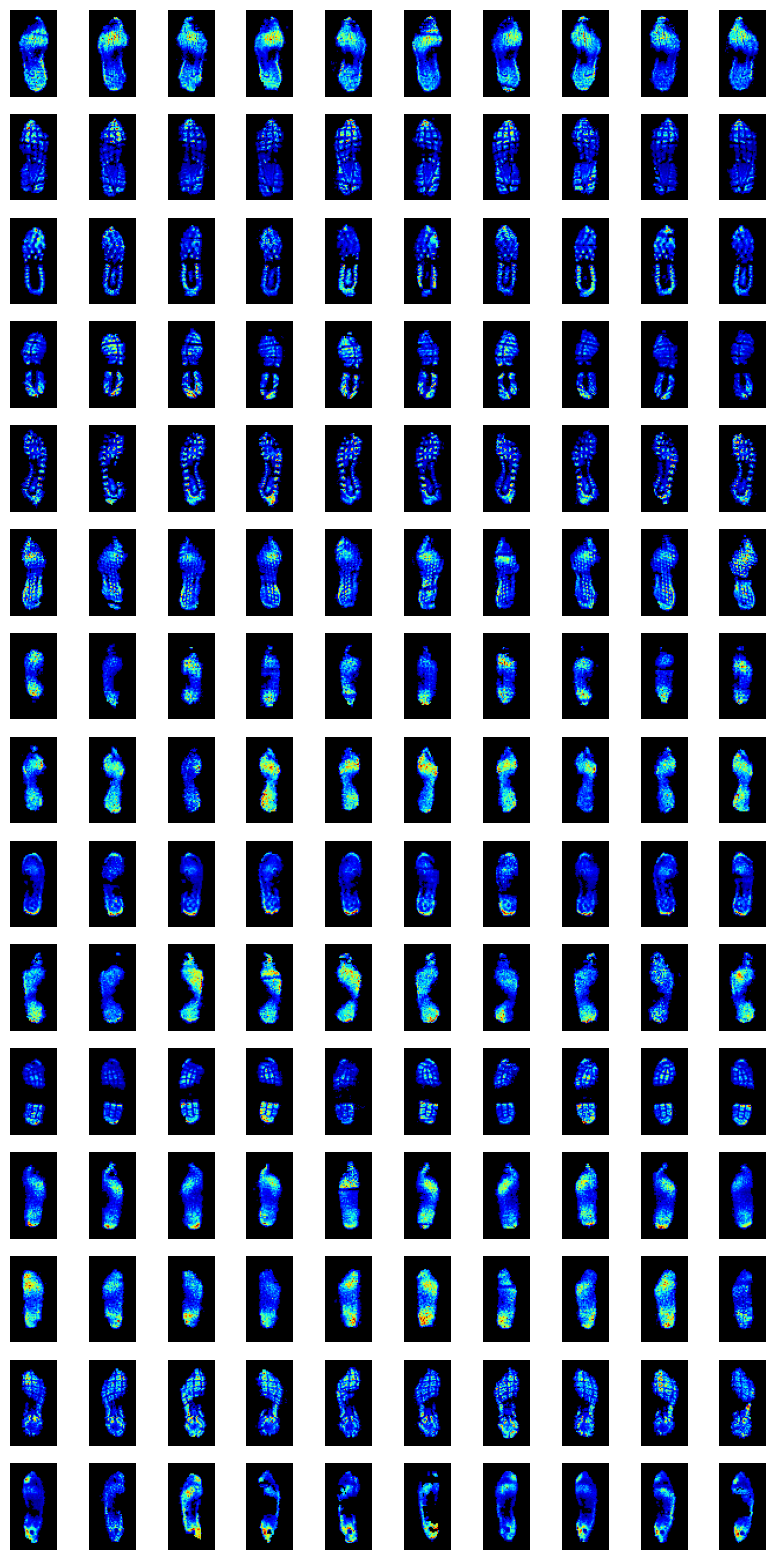

In [16]:
# define colormap
jet = mpl.colormaps['jet'](np.linspace(0, 1, 256))
jet[0] = [0,0,0,1]
cmap = mpl.colors.ListedColormap(jet)

fig,ax = plt.subplots(15,10,figsize = (10,20))
ax = ax.flatten(order = 'C')
for i,key in enumerate(footsteps_ref):
    footstep = footsteps_ref[key]

    ax[i].imshow(footstep.max(0),cmap = cmap)
    ax[i].set_axis_off()

plt.show()


### Define a Dataset Class for the Reference and Probe Sets

Both the Reference and Probe datasets are in the same format, so this dataset class can be used for both. The exception is that the reference dataset has true identity labels (`ParticipantID`) while the probe set has only claimed identity labels (`ClaimID`). The argument `ref` can be used to specify whether to use the reference set format (`True`) or the probe set format (`False`).

Like with the training dataset, this dataset class automatically flips all right footsteps along their x-axis. 

In [17]:
class Test_Dataset(Dataset):
    def __init__(self,data_dict,metadata,transform = None, ref = True):
        self.data_dict = data_dict
        self.footstep_ID = list(data_dict.keys())
        self.side = metadata['Side'].to_numpy()
        self.transform = transform

        if ref: # reference set
            self.labels = metadata['ParticipantID'].to_numpy()
        else: # probe set
            self.labels = metadata['ClaimID'].to_numpy()

        self.n_classes = np.unique(self.labels).shape[0]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        footstep = self.data_dict[self.footstep_ID[idx]]

        # flip right footsteps along x axis
        if self.side[idx] == 'Right':
            footstep = np.flip(footstep,axis = 2)
        
        # add dimension for channel: shape (1,101,75,40) (channel,time,y,x)
        footstep = footstep[None,:,:,:]

        x = torch.from_numpy(footstep.astype(np.float32)) # TODO: check datatype
        y = torch.tensor(self.labels[idx])
        
        if self.transform:
            x = self.transform(x)

        return x, y


### Get Reference Embeddings using Trained CNN

Pass the reference footsteps through the trained CNN to obtain 512 features for each footstep. 

In [18]:
clf.eval()

dataset_ref = Test_Dataset(footsteps_ref, metadata_ref,transform = transform_fn)
dataloader_ref = DataLoader(dataset_ref, batch_size=batch_sz, shuffle=False)

ref_embeds = []
with torch.no_grad():

    for id_batch, (x_batch, y_batch) in enumerate(dataloader_ref):

        x_batch =  x_batch.to(device)

        y_batch_pred,embeds = clf(x_batch)
        embeds = embeds.cpu()
        ref_embeds.append(embeds)

ref_embeds = np.concatenate(ref_embeds, axis = 0)

print('Reference Feature Set:',ref_embeds.shape)


Reference Feature Set: (150, 512)


/home/robyn/StepUP/StepUP-P150/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


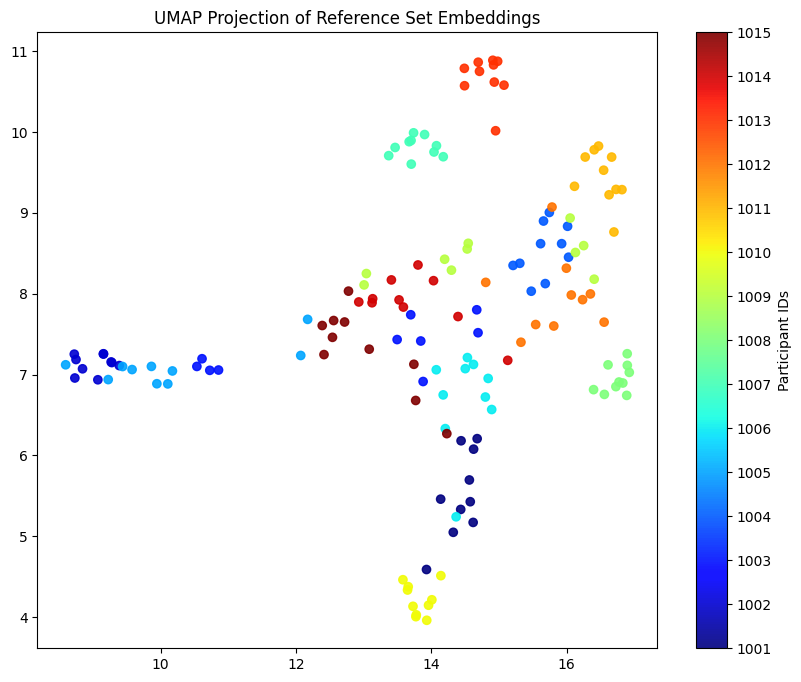

In [19]:
reducer = umap.UMAP()
umap_proj = reducer.fit_transform(ref_embeds) # use umap reducer fit to training set

fig,ax = plt.subplots(figsize=(10, 8))
scatter = plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=dataset_ref.labels, cmap='jet', vmin = dataset_ref.labels.min(), vmax = dataset_ref.labels.max(), alpha=0.9)
plt.colorbar(scatter,ticks = np.unique(dataset_ref.labels),label = 'Participant IDs')
plt.title("UMAP Projection of Reference Set Embeddings")
plt.show()

## Step 3: Perform Verification on the Probe Set

### Load Probe Samples

There are 10,000 probe samples with claimed identities that need to be verified. These are in the same format as the reference samples, with a single metadata file containing the claims and a single .npz file with the footsteps stored in a dictionary. 

In [20]:
metadata_probe = pd.read_csv(datapath_probe / 'probe_metadata.csv',index_col = 'Index')
footsteps_probe = np.load(datapath_probe / 'probe_data.npz')

metadata_probe.head()

,ClaimID,Side
Index,,
0,1001,Right
1,1015,Right
2,1009,Left
3,1001,Right
4,1008,Left


### Get Embeddings for Probe Set

Create a dataloader and pass the probe samples through the trained network for feature extraction.

In [21]:
clf.eval()

dataset_probe = Test_Dataset(footsteps_probe, metadata_probe,transform = transform_fn,ref = False)
dataloader_probe = DataLoader(dataset_probe, batch_size=batch_sz, shuffle=False)

probe_embeds = []
with torch.no_grad():

    for id_batch, (x_batch, y_batch) in enumerate(dataloader_probe):

        x_batch =  x_batch.to(device)

        y_batch_pred,embeds = clf(x_batch)
        embeds = embeds.cpu()
        probe_embeds.append(embeds)

probe_embeds = np.concatenate(probe_embeds, axis = 0)

print('Probe Feature Set:',probe_embeds.shape)

Probe Feature Set: (10000, 512)


Plot a umap projection of the probe set embeddings. Note that many of the claimed identities are incorrect, so we don't expect these classes to cluster nicely. 

/home/robyn/StepUP/StepUP-P150/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


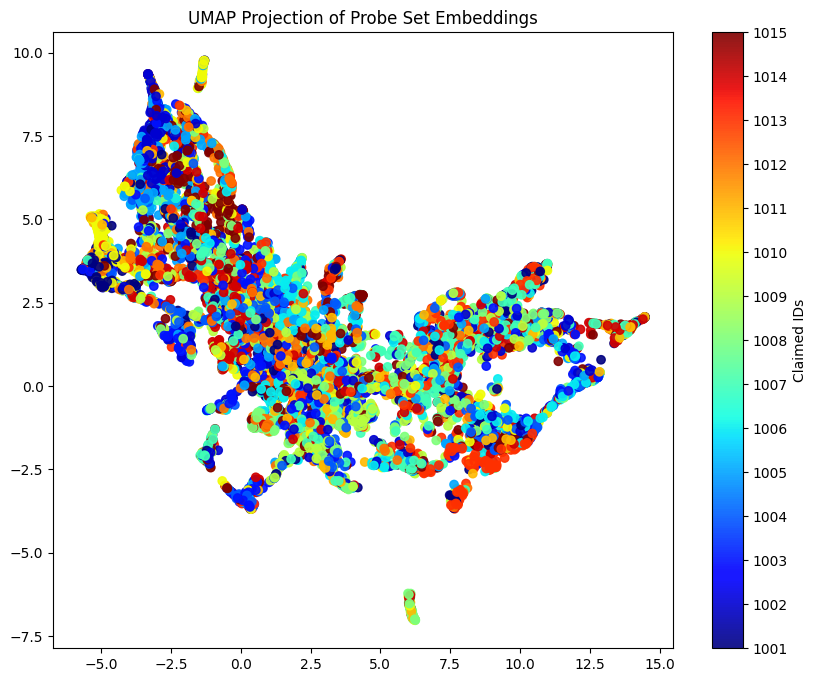

In [22]:
reducer = umap.UMAP()
umap_proj = reducer.fit_transform(probe_embeds) 

fig,ax = plt.subplots(figsize=(10, 8))
scatter = plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=dataset_probe.labels, cmap='jet', vmin = dataset_probe.labels.min(), vmax = dataset_probe.labels.max(), alpha=0.9)
plt.colorbar(scatter,ticks = np.unique(dataset_probe.labels),label = 'Claimed IDs')
plt.title("UMAP Projection of Probe Set Embeddings")
plt.show()

### Compute Similarity Scores for Each Sample in Probe Set

Compare each probe to the reference samples to obtain a similarity score. Here, we use cosine distance for comparison. There are three comparisons performed: 
1. Distance between the probe and the nearest reference for the claimed user
2. Distance between the probe and the references for users *other* than the claimed user (i.e., the cohort)
3. Distance between the references for the claimed user and the references for the cohort 

Comparisons 2 and 3 are used for score normalization, based on a combination of the popular Z-norm and T-norm techniques. The result is a similarity score between 0 and 1 for each of the probe samples.

**Note**: here, we make use of the left and right labels to compare footsteps to those of the same side. This accounts for potential gait asymmetries. 

In [23]:
# compute distance between all pairs of reference samples (for Z-norm score normalization)
dist_metric = 'cosine'
ref_dist = squareform(pdist(ref_embeds,dist_metric))

all_score = []
for claim,feat,side in zip(dataset_probe.labels,probe_embeds,dataset_probe.side):
    user_idx = dataset_ref.labels == claim
    cohort_idx = dataset_ref.labels != claim
    side_idx = dataset_ref.side == side

    # for Z-norm score normalization
    # get distance scores between (left or right) references for the claimed user and the cohort (other users)
    y_Z = ref_dist[np.ix_(user_idx & side_idx,cohort_idx)].flatten()
    mu_Z = y_Z.mean()
    sd_Z = y_Z.std()

    # for T-norm score normalization
    # get distance between probe sample and cohort reference samples
    y_T = cdist(feat[None,:],ref_embeds[cohort_idx],dist_metric)
    mu_T = y_T.mean()
    sd_T = y_T.std()

    # get distance between probe and claimed user's nearest (left or right) reference sample 
    y = cdist(feat[None,:],ref_embeds[user_idx & side_idx],dist_metric).min() 

    # combine computed mean and sd for symmetric normalization
    mu = (mu_Z*sd_T + mu_T*sd_Z)/(sd_Z + sd_T)
    sd = (2*sd_Z*sd_T)/(sd_Z + sd_T)

    # use sigmoid to convert between 0 and 1
    y_sig = 1/(1 + np.exp(-(y - mu)/sd))

    # convert from dissimilarity to similarity score
    score = 1 - y_sig

    all_score.append(score)

all_score = np.array(all_score) 

Select a score threshold for making match/non-match decisions. Probes will be considered a 'match' if the similarity is greater than or equal to the threshold, and a 'non-match' otherwise. Here, we select a threshold of 0.8.  

In [24]:
threshold = np.array([0.8])

## Step 4. Export Results in CodaBench Submission Format

Finally, write the similarity scores and threshold to text files for submission. This function packages these into a zip file that can be uploaded to the CodaBench platform. 

In [25]:
#  - scores: (10000,) element numpy array in range [0.0,1.0] 
#  - threshold: (1,) element numpy array in range [0.0, 1.0]
#  - output: (optional) filename of created zipfile

def package_predictions_for_submission(scores, threshold, output=pathlib.Path('./submission.zip')):
  
  filename_variable_pairs = {
    'threshold.txt': threshold,
    'scores.txt': scores,
  }

  # The most straightforward way to populate a zip file is with actual files on disk
  # Therefore, temporarily create each file in the working directory  
  for f, d in filename_variable_pairs.items():
    np.savetxt(f, d)

  # Create the zip file
  with zipfile.ZipFile(output, mode='w') as z:
    for f, _ in filename_variable_pairs.items():
      z.write(f)
  
  # ...the cleanup after ourselves to avoid clutter
  for f, _ in filename_variable_pairs.items():
    os.remove(f)

  print(f'Successfully created CodaBench submission file: `{output}`. Upload this zip file to CodaBench to complete your submission.')

In [ ]:
package_predictions_for_submission(all_score, threshold, output=pathlib.Path('./submission_example.zip'))

Successfully created CodaBench submission file: `submission_example.zip`. Upload this zip file to CodaBench to complete your submission.
